# Checking with the code by printing one image and display at each step what it is doing

In [ ]:
# MASK_PATH = "dataset/Whole_Slides_Segments_Processed/inf/Boiling-2min/HumanColonC/predicted_mask/"
# RGB_PATH  = "dataset/Whole_Slides_Segments_Processed/CDX2_Data/Boiling-2min/HumanColonC/"

In [45]:
# === YOUR ORIGINAL IMPORTS (unchanged) ===
import pdb
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
# for rotation
import argparse
import imutils
import glob
import imgaug.augmenters as iaa

In [46]:
# === YOUR ORIGINAL FUNCTIONS (UNCHANGED) ===

#step 1: find an ellipse to fit the contour of the u shape
# input: original image, RGB valued
# output: contour, ellipse-> the first ellipse, gray -> grayscaled image

# def find_ellipse(image):

#     gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
#     #gray = cv2.cvtColor(cv2.UMat(image), cv2.COLOR_RGB2GRAY)
#     ret, thresh = cv2.threshold(gray, 127, 255, 0)
    
#     # find contours
#     contours, hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
#     # find the biggest contour
#     contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
#     cnt = max(contour_sizes, key=lambda x: x[0])[1]
#     #cnt = contours[0]
    
#     #contours,hierarchy = cv2.findContours(thresh, 1, 2)
#     #cnt = contours[0]
#     #cv2.drawContours(image,cnt, -1, 100, -1)
#     #ellipse = cv2.fitEllipse(cnt)
#     while True:
#         try:
#             ellipse = cv2.fitEllipse(cnt)
#             break
#         except:
#             flag = 1
#             print("Oops!  This gland is invalid or circular")
#             return cnt, ([0,0],[0,0]), gray
#             break
    
#     #cv2.ellipse(gray,ellipse,(0,100,0),50)
    
#     return cnt,ellipse, gray

def find_ellipse(image):
    """
    Fit an ellipse to the entire white region (all foreground pixels).
    This makes the angle represent the whole U even if the base has a small gap.
    Returns (cnt, ellipse, gray) with the same signature as your original function.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Robust binarization (Otsu) so we grab the full mask area
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Collect ALL foreground points (works even if there are multiple components)
    pts = cv2.findNonZero(mask)  # shape: (N,1,2), dtype=int32
    if pts is None or len(pts) < 5:
        print("No enough foreground to fit ellipse.")
        return np.zeros((0,1,2), dtype=np.int32), ([0,0],[0,0]), gray

    # Optional downsample for speed on very large masks (keeps orientation)
    if len(pts) > 8000:
        idx = np.random.choice(len(pts), 8000, replace=False)
        pts = pts[idx]

    pts = pts.astype(np.float32)
    ellipse = cv2.fitEllipse(pts)  # ((cx,cy), (a,b), angle_deg)

    # For API compatibility, also return the largest external contour as 'cnt'
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt = max(contours, key=cv2.contourArea) if contours else np.zeros((0,1,2), np.int32)

    return cnt, ellipse, gray


# # step2: rotate the image by the angle of the ellipse
# # make the image horizontal
# def rotate1(image,elps):
#     flag = 0
    
#     angle  = elps[2]
#     print("rotate1(): ellipse angle =", angle)
#     if angle > 90:
#         rotated = imutils.rotate_bound(image, 270-angle)
#     elif angle == 0:
#         flag = 1
#         rotated = image
#     else:    
#         rotated = imutils.rotate_bound(image, 90-angle)
    
#     rotated_gray = cv2.cvtColor(rotated,cv2.COLOR_BGR2GRAY)
#     ret, thresh = cv2.threshold(rotated_gray, 127, 255, 0)
#     contours,hierarchy = cv2.findContours(thresh, 1, 2)
#     contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
#     cnt = max(contour_sizes, key=lambda x: x[0])[1]
#     while True:
#         try:
#             ellipse2 = cv2.fitEllipse(cnt)
#             break
#         except:
#             flag = 1
#             print('here flag2')
#             print(flag)
#             print("Oops!  This gland is invalid")
#             return rotated, rotated_gray, ([0,0],[0,0]), flag
    
#     cv2.ellipse(rotated_gray,ellipse2,(255,255,255),10)
    
#     return rotated, rotated_gray, ellipse2, flag

def rotate1(image, elps):
    """
    Rotate by ellipse angle (unchanged rule) and then fit a NEW ellipse
    on ALL foreground pixels of the rotated image (Otsu + findNonZero).
    """
    flag = 0
    angle  = elps[2]
    if angle > 90:
        rotated = imutils.rotate_bound(image, 270 - angle)
    elif angle == 0:
        flag = 1
        rotated = image
    else:
        rotated = imutils.rotate_bound(image, 90 - angle)

    rotated_gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    # Re-binarize robustly (rotation introduces interpolation)
    _, thr = cv2.threshold(rotated_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    pts = cv2.findNonZero(thr)  # (N,1,2)
    if pts is None or len(pts) < 5:
        flag = 1
        print("No enough foreground to fit ellipse (rotate1).")
        return rotated, rotated_gray, ([0,0],[0,0]), flag

    if len(pts) > 8000:
        idx = np.random.choice(len(pts), 8000, replace=False)
        pts = pts[idx]

    pts = pts.astype(np.float32)
    try:
        ellipse2 = cv2.fitEllipse(pts)
    except:
        flag = 1
        print("fitEllipse failed on rotated mask.")
        return rotated, rotated_gray, ([0,0],[0,0]), flag

    # optional: draw ellipse on gray for visualization (kept like your code)
    cv2.ellipse(rotated_gray, ellipse2, (255,255,255), 10)

    return rotated, rotated_gray, ellipse2, flag

# connected components and direction
def direc_det(image):
    
    cnt,elps, gray_elips = find_ellipse(image)
    rotated, rotated_gray, ellipse2, flag = rotate1(image, elps)
    gray = cv2.cvtColor(rotated,cv2.COLOR_BGR2GRAY)    
    
    print('flag = ', flag)
    
    if flag == 0:
        left_ori = gray[:,:int(ellipse2[0][0])]
        right_ori = gray[:,int(ellipse2[0][0]):]

        ret1, thresh1 = cv2.threshold(left_ori,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        ret2, thresh2 = cv2.threshold(right_ori,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

        nlabels_left, labels_left, stats_left, centroids_left = cv2.connectedComponentsWithStats(thresh1)
        nlabels_right, labels_r, stats_r, centroids_r = cv2.connectedComponentsWithStats(thresh2)

        if nlabels_left > nlabels_right:
            direction = 'left'
            print(direction)
            print('left = ', nlabels_left)
            print('right = ', nlabels_right)
            
        elif nlabels_right >=nlabels_left:
            direction = 'right'
            print(direction)
            print('left = ', nlabels_left)
            print('right = ', nlabels_right)
    
    elif flag == 1:
        left_ori = gray[:,:int(len(gray/2))]
        right_ori = gray[:,int(len(gray/2)):]

        ret1, thresh1 = cv2.threshold(left_ori,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        ret2, thresh2 = cv2.threshold(right_ori,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

        nlabels_left, labels_left, stats_left, centroids_left = cv2.connectedComponentsWithStats(thresh1)
        nlabels_right, labels_r, stats_r, centroids_r = cv2.connectedComponentsWithStats(thresh2)
        
        if nlabels_left < nlabels_right:
            direction = 'left'
            print(direction)
            print('left = ', nlabels_left)
            print('right = ', nlabels_right)
            
        elif nlabels_left >= nlabels_right:
            direction = 'right'
        
            print(direction)
            print('left = ', nlabels_left)
            print('right = ', nlabels_right)
            
    return rotated, elps, direction



def rotate2(img, direction):
    if direction == 'left':
        rotated = imutils.rotate_bound(img, -90)
    else:
        rotated = imutils.rotate_bound(img, 90)
    return rotated

def fit_box(original):
    mask = original > 0
    mask = mask.all(2)
    coords = np.argwhere(mask)
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1
    return original[x0:x1, y0:y1]




def iterate_dir_save(mask_directory, original_directory, des_dir):
    try:
        os.mkdir(des_dir)
    except:
        pass
    print(original_directory)
    for rgb_img_path in os.listdir(original_directory):
        mask_names = glob.glob(os.path.join(mask_directory, os.path.splitext(os.path.basename(rgb_img_path))[0] + '_*.png'))
        for mask_path in mask_names:
            if mask_path.endswith(".png"):
                try:
                    print(mask_path)
                    curr_img = cv2.imread(mask_path)
                    curr_img_height, curr_img_width = curr_img.shape[:2]
                    rgb_img = cv2.resize(cv2.imread(original_directory + rgb_img_path), (curr_img_width, curr_img_height))
                    augmentation = iaa.Sequential([
                        iaa.PadToAspectRatio(1.5, position="center"),
                        iaa.Resize({"height": 768, "width": 1024}),
                    ], random_order=False)
                    rgb_img = augmentation.augment_image(rgb_img)
                    rotated, elps, direction = direc_det(curr_img)
                    rgb_img, _, _, _ = rotate1(rgb_img, elps)
                    rotated2 = rotate2(rotated, direction)
                    rgb_img = rotate2(rgb_img, direction)
                    rotated2 = cv2.cvtColor(rotated2, cv2.COLOR_BGR2GRAY)
                    res = cv2.bitwise_and(rgb_img, rgb_img, mask=rotated2)
                    res = fit_box(res)
                except:
                    continue
                status = cv2.imwrite(os.path.join(des_dir, os.path.basename(mask_path)), res)
                print("Image written to file-system : ", status)
                continue
            else:
                continue

Loading files:
  MASK: dataset/test/predicted_mask/3_5.png
  RGB : dataset/test/Images/3.png
Original shapes: mask=(768, 1024, 3), rgb=(1267, 1268, 3)


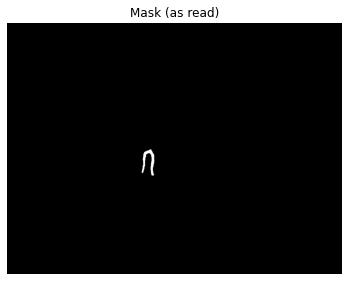

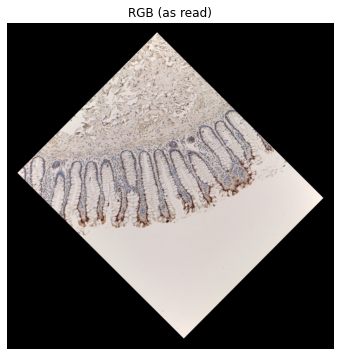


[Preview] Threshold used inside find_ellipse()


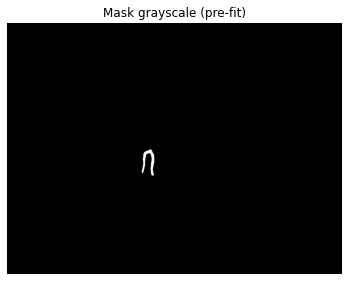

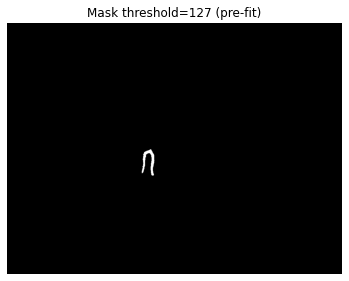

find_ellipse() returned ellipse: ((431.01580810546875, 434.7320861816406), (31.290939331054688, 90.29705810546875), 3.1370017528533936)


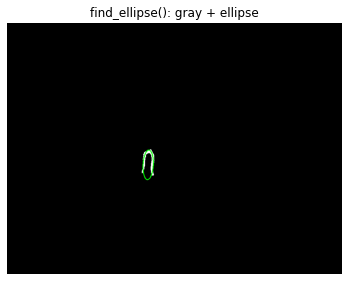


Resizing RGB to mask size then applying your imgaug sequence (PadToAspectRatio -> Resize)


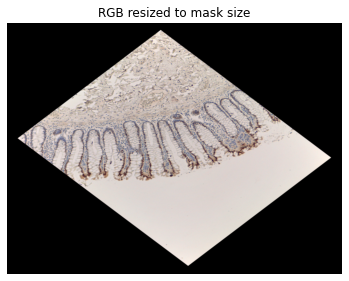

After augmentation: (768, 1024, 3)


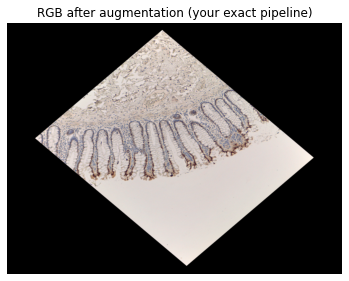


Calling direc_det(mask) to get rotated mask + direction (your logic):
flag =  0
right
left =  2
right =  3
direc_det(): direction = right


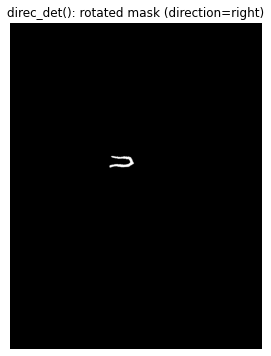


Calling rotate1(mask, elps) to show rotated_gray + ellipse2 (same as inside direc_det)


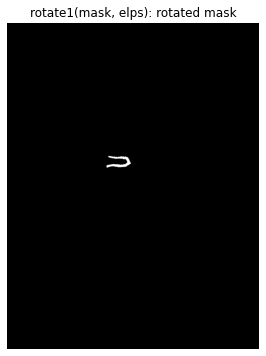

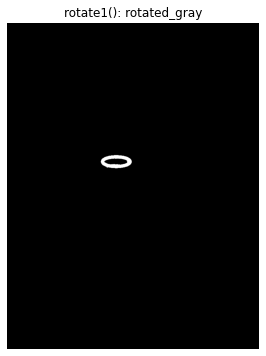

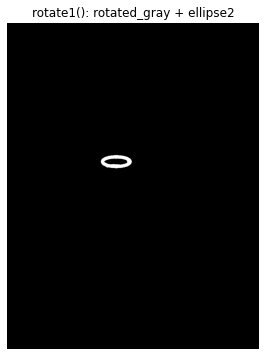


Rotating the augmented RGB with rotate1(rgb_aug, elps) (your logic):


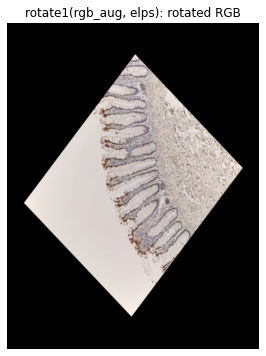


Final ±90° rotation using rotate2(...) with direction from direc_det():


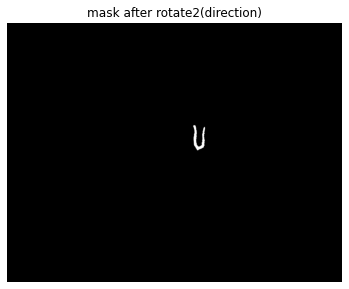

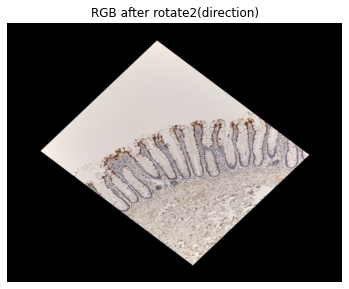


Applying bitwise_and with rotated mask (converted to gray) on rotated RGB


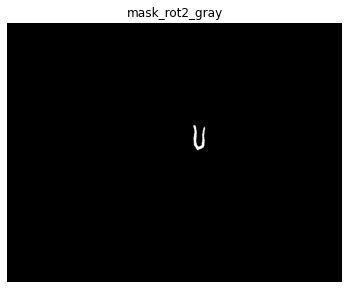

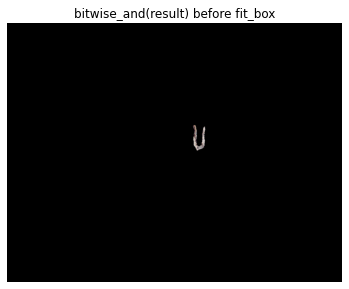

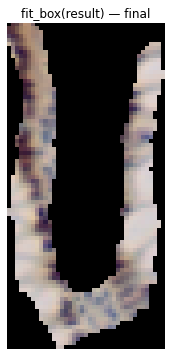


 Debug run finished. No files were saved.


In [48]:
# === DEBUG / DISPLAY HELPERS (added; do not alter your logic) ===

def show(img, title="", gray=False, size=6):
    plt.figure(figsize=(size, size))
    if gray or (img.ndim == 2):
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis("off")
    plt.show()

def debug_one(mask_path, rgb_path):
    """
    Single-image debug runner that follows your exact steps and SHOWS everything.
    No files are saved. Your functions are used as-is.
    """
    print("="*80)
    print(f"Loading files:\n  MASK: {mask_path}\n  RGB : {rgb_path}")
    mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
    rgb  = cv2.imread(rgb_path,  cv2.IMREAD_COLOR)
    if mask is None:
        print(" Could not read mask.")
        return
    if rgb is None:
        print(" Could not read RGB image.")
        return

    print(f"Original shapes: mask={mask.shape}, rgb={rgb.shape}")
    show(mask, "Mask (as read)")
    show(rgb,  "RGB (as read)")

    # --- Visualize thresholding used inside find_ellipse ---
    print("\n[Preview] Threshold used inside find_ellipse()")
    gray0 = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    _, thr0 = cv2.threshold(gray0, 127, 255, 0)
    show(gray0, "Mask grayscale (pre-fit)", gray=True)
    show(thr0,  "Mask threshold=127 (pre-fit)", gray=True)

    # 1) Your find_ellipse() on mask
    cnt, elps, gray = find_ellipse(mask)
    print("find_ellipse() returned ellipse:", elps)
    vis1 = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)
    try:
        cv2.ellipse(vis1, elps, (0,255,0), 2)
    except:
        pass
    show(vis1, "find_ellipse(): gray + ellipse")

    # 2) Prep RGB same way you do (resize to mask size, then pad+resize augmentation)
    print("\nResizing RGB to mask size then applying your imgaug sequence (PadToAspectRatio -> Resize)")
    h, w = mask.shape[:2]
    rgb_rs = cv2.resize(rgb, (w, h))
    show(rgb_rs, "RGB resized to mask size")
    augmentation = iaa.Sequential([
        iaa.PadToAspectRatio(1.5, position="center"),
        iaa.Resize({"height": 768, "width": 1024}),
    ], random_order=False)
    rgb_aug = augmentation.augment_image(rgb_rs)
    print("After augmentation:", rgb_aug.shape)
    show(rgb_aug, "RGB after augmentation (your exact pipeline)")

    # 3) Use your direc_det() on mask (this internally calls find_ellipse() and rotate1())
    print("\nCalling direc_det(mask) to get rotated mask + direction (your logic):")
    rotated_mask, elps_out, direction = direc_det(mask)
    print("direc_det(): direction =", direction)
    show(rotated_mask, f"direc_det(): rotated mask (direction={direction})")

    # Also show the rotated_gray and ellipse2 that rotate1() computes (for transparency)
    print("\nCalling rotate1(mask, elps) to show rotated_gray + ellipse2 (same as inside direc_det)")
    mask_rot1, mask_rot1_gray, ellipse2, flag = rotate1(mask, elps)
    show(mask_rot1, "rotate1(mask, elps): rotated mask")
    show(mask_rot1_gray, "rotate1(): rotated_gray", gray=True)
    vis2 = cv2.cvtColor(mask_rot1_gray, cv2.COLOR_GRAY2BGR)
    try:
        cv2.ellipse(vis2, ellipse2, (255,255,255), 2)
    except:
        pass
    show(vis2, "rotate1(): rotated_gray + ellipse2")

    # 4) Rotate the augmented RGB using the SAME ellipse (your pipeline does rotate1 on RGB with elps)
    print("\nRotating the augmented RGB with rotate1(rgb_aug, elps) (your logic):")
    rgb_rot1, _, _, _ = rotate1(rgb_aug, elps)
    show(rgb_rot1, "rotate1(rgb_aug, elps): rotated RGB")

    # 5) Final +/- 90° rotation via rotate2() using the direction from direc_det()
    print("\nFinal ±90° rotation using rotate2(...) with direction from direc_det():")
    mask_rot2 = rotate2(rotated_mask, direction)
    rgb_rot2  = rotate2(rgb_rot1,    direction)
    show(mask_rot2, "mask after rotate2(direction)")
    show(rgb_rot2,  "RGB after rotate2(direction)")

    # 6) Apply mask to RGB exactly like your code
    print("\nApplying bitwise_and with rotated mask (converted to gray) on rotated RGB")
    mask_rot2_gray = cv2.cvtColor(mask_rot2, cv2.COLOR_BGR2GRAY)
    show(mask_rot2_gray, "mask_rot2_gray", gray=True)

    if rgb_rot2.shape[:2] != mask_rot2_gray.shape[:2]:
        print("Shape mismatch:",
              "rgb_rot2", rgb_rot2.shape, "vs", "mask_rot2_gray", mask_rot2_gray.shape,
              "→ Skipping bitwise_and to avoid error (this mirrors why your pipeline may fail).")
    else:
        res = cv2.bitwise_and(rgb_rot2, rgb_rot2, mask=mask_rot2_gray)
        show(res, "bitwise_and(result) before fit_box")
        try:
            cropped = fit_box(res)
            show(cropped, "fit_box(result) — final")
        except Exception as e:
            print("fit_box() failed:", e)

    print("\n Debug run finished. No files were saved.")
    print("="*80)


# --- RUN DEBUG ON ONE PAIR (edit these two paths) ---
MASK_PATH = "dataset/test/predicted_mask/3_5.png"
RGB_PATH  = "dataset/test/Images/3.png"

# Uncomment after setting paths:
debug_one(MASK_PATH, RGB_PATH)



# Code to split into accepted, rejected , and fragmented

In [ ]:
# =========================
# UPDATED splitter (handles tiny holes; stricter O-rule; skimage 0.15 compatible)
# =========================

import os, shutil, glob
import numpy as np
import cv2

from skimage.morphology import skeletonize, remove_small_objects
from skimage.measure import label


MIN_OBJ_AREA       = 32          
CLOSE_KERNEL_SIZE  = 3          
HOLE_MIN_ABS       = 64         
HOLE_MIN_FRAC      = 0.01      
GOOD_U_ENDPTS_MIN  = 2           
GOOD_U_ENDPTS_MAX  = 4

def read_mask_binary(path):
    """Read mask → bool foreground, lightly cleaned for classification."""
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None

    _, binv = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binv = (binv > 0)

    if binv.any():
        binv = remove_small_objects(binv, min_size=MIN_OBJ_AREA)

    ksz = CLOSE_KERNEL_SIZE
    if ksz and ksz > 1:
        ker = np.ones((ksz, ksz), np.uint8)
        binv = cv2.morphologyEx(binv.astype(np.uint8)*255, cv2.MORPH_CLOSE, ker) > 0

    return binv

def count_endpoints(skel_bool):
    """Endpoints on 8-neighborhood skeleton: pixels with exactly one neighbor."""
    if skel_bool is None or skel_bool.sum() == 0:
        return 0
    skel_u8 = skel_bool.astype(np.uint8)
    kernel = np.array([[1,1,1],
                       [1,0,1],
                       [1,1,1]], dtype=np.uint8)
    nbrs = cv2.filter2D(skel_u8, ddepth=cv2.CV_16S, kernel=kernel, borderType=cv2.BORDER_CONSTANT)
    return int(np.sum((skel_u8 == 1) & (nbrs == 1)))

def count_large_holes(binary_mask):
    """
    Count holes but IGNORE tiny ones.
    Strategy: label the INVERTED mask; any component NOT touching the border
    is a hole. Only keep those with area >= max(HOLE_MIN_ABS, HOLE_MIN_FRAC * foreground_area).
    """
    if binary_mask is None:
        return 0, 0
    fg_area = int(binary_mask.sum())
    if fg_area == 0:
        return 0, 0

    min_hole_area = max(HOLE_MIN_ABS, int(HOLE_MIN_FRAC * fg_area))

    inv = ~binary_mask
    lbl = label(inv, connectivity=2)  # 0 = background
    nlabels = int(lbl.max())
    if nlabels == 0:
        return 0, 0

 
    border_labels = np.unique(np.concatenate([lbl[0,:], lbl[-1,:], lbl[:,0], lbl[:,-1]]))
    hole_labels = [i for i in range(1, nlabels+1) if i not in border_labels]

    total_holes = len(hole_labels)
    if total_holes == 0:
        return 0, 0


    large = 0
    for i in hole_labels:
        area = int((lbl == i).sum())
        if area >= min_hole_area:
            large += 1
    return large, total_holes

def classify_mask(binary_mask):
    """
    Returns one of: 'good_u', 'fragmented_u', 'o_shape', 'rejected'
    O-shape (loop): single component AND has ≥1 large hole AND endpoints ≤ 1
    Fragmented U:   no large holes AND (components ≥2 OR endpoints ≥3)
    Good U:         no large holes AND single component AND endpoints in [2,4]
    """
    if binary_mask is None or binary_mask.sum() == 0:
        return "rejected", {"reason": "empty"}

    num_comp = int(label(binary_mask, connectivity=2).max())
    large_holes, total_holes = count_large_holes(binary_mask)

    skel = skeletonize(binary_mask)
    endpoints = count_endpoints(skel)

  
    if (num_comp == 1) and (large_holes >= 1) and (endpoints <= 1):
        return "o_shape", {"components": num_comp, "large_holes": large_holes,
                           "total_holes": total_holes, "endpoints": endpoints}

    
    if (large_holes == 0) and ((num_comp >= 2) or (endpoints >= 3)):
        return "fragmented_u", {"components": num_comp, "large_holes": large_holes,
                                "total_holes": total_holes, "endpoints": endpoints}

    if (large_holes == 0) and (num_comp >= 1) and (GOOD_U_ENDPTS_MIN <= endpoints <= GOOD_U_ENDPTS_MAX):
        return "good_u", {"components": num_comp, "large_holes": large_holes,
                          "total_holes": total_holes, "endpoints": endpoints}


    return "rejected", {"components": num_comp, "large_holes": large_holes,
                        "total_holes": total_holes, "endpoints": endpoints, "reason": "uncertain"}

def split_directory_single(mask_dir, out_dir, pattern="*.png"):
    """
    Scan one masks folder and split into accepted/fragmented/rejected.
    Each original mask is COPIED (not moved). Safe to re-run.
    """
    acc_dir = os.path.join(out_dir, "accepted")
    frag_dir = os.path.join(out_dir, "fragmented")
    rej_dir = os.path.join(out_dir, "rejected")
    os.makedirs(acc_dir, exist_ok=True)
    os.makedirs(frag_dir, exist_ok=True)
    os.makedirs(rej_dir, exist_ok=True)

    paths = sorted(glob.glob(os.path.join(mask_dir, pattern)))
    print(f"[INFO] Found {len(paths)} mask(s) in: {mask_dir}")

    n_good = n_frag = n_rej = 0
    for p in paths:
        binv = read_mask_binary(p)
        cls, meta = classify_mask(binv)
        base = os.path.basename(p)

        if cls == "good_u":
            dst = os.path.join(acc_dir, base); n_good += 1
        elif cls == "fragmented_u":
            dst = os.path.join(frag_dir, base); n_frag += 1
        elif cls == "o_shape":
            dst = os.path.join(rej_dir, base); n_rej += 1
        else:  # 'rejected'
            dst = os.path.join(rej_dir, base); n_rej += 1

        shutil.copy2(p, dst)
        print(f"  • {base:>30s} -> {cls:12s}  {meta}")

    print("\n[SUMMARY]")
    print(f"  accepted (good U):   {n_good}")
    print(f"  fragmented U:        {n_frag}")
    print(f"  rejected (O/other):  {n_rej}")
    print(f"  Output root: {out_dir}")

# ====== USAGE (edit these two and run) ======
MASK_DIR = "dataset/test/predicted_mask/"
OUTPUT_DIR = "dataset/temp/"
split_directory_single(MASK_DIR, OUTPUT_DIR)





[INFO] Found 177 mask(s) in: dataset/test/predicted_mask/
  • 1005466.svs (1, 12698, 31042, 1037, 529)_0.png -> fragmented_u  {'components': 1, 'large_holes': 0, 'total_holes': 0, 'endpoints': 3}
  • 1005466.svs (1, 21547, 39155, 2169, 1796)_0.png -> fragmented_u  {'components': 2, 'large_holes': 0, 'total_holes': 0, 'endpoints': 5}
  • 1005466.svs (1, 21547, 39155, 2169, 1796)_1.png -> fragmented_u  {'components': 1, 'large_holes': 0, 'total_holes': 0, 'endpoints': 3}
  • 1005466.svs (1, 21547, 39155, 2169, 1796)_2.png -> fragmented_u  {'components': 2, 'large_holes': 0, 'total_holes': 0, 'endpoints': 4}
  • 1005466.svs (1, 21547, 39155, 2169, 1796)_4.png -> fragmented_u  {'components': 1, 'large_holes': 0, 'total_holes': 0, 'endpoints': 3}
  • 1005474.svs (1, 3467, 30049, 2161, 930)_0.png -> fragmented_u  {'components': 2, 'large_holes': 0, 'total_holes': 0, 'endpoints': 4}
  • 1005474.svs (1, 3467, 30049, 2161, 930)_1.png -> good_u        {'components': 1, 'large_holes': 0, 'total_h

# Final code mirroring src directory for splitting

In [36]:
# =========================
# UPDATED splitter (handles tiny holes; stricter O-rule; skimage 0.15 compatible)
# =========================
import os, shutil, glob
import numpy as np
import cv2

from skimage.morphology import skeletonize, remove_small_objects
from skimage.measure import label

# ---- tunables (adjust if needed) ----
MIN_OBJ_AREA       = 32          # remove tiny white specks
CLOSE_KERNEL_SIZE  = 3           # 3x3 closing to kill pinholes
HOLE_MIN_ABS       = 64          # ignore holes smaller than this (in pixels)
HOLE_MIN_FRAC      = 0.01        # ...or smaller than this *foreground* fraction
GOOD_U_ENDPTS_MIN  = 2           # endpoints in [2,4] → good U
GOOD_U_ENDPTS_MAX  = 4

def read_mask_binary(path):
    """Read mask → bool foreground, lightly cleaned for classification."""
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    # Otsu binarization
    _, binv = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    binv = (binv > 0)

    # Remove very small white specks
    if binv.any():
        binv = remove_small_objects(binv, min_size=MIN_OBJ_AREA)

    # Light morphological closing to eliminate pinholes (won't bridge big gaps)
    ksz = CLOSE_KERNEL_SIZE
    if ksz and ksz > 1:
        ker = np.ones((ksz, ksz), np.uint8)
        binv = cv2.morphologyEx(binv.astype(np.uint8)*255, cv2.MORPH_CLOSE, ker) > 0

    return binv

def count_endpoints(skel_bool):
    """Endpoints on 8-neighborhood skeleton: pixels with exactly one neighbor."""
    if skel_bool is None or skel_bool.sum() == 0:
        return 0
    skel_u8 = skel_bool.astype(np.uint8)
    kernel = np.array([[1,1,1],
                       [1,0,1],
                       [1,1,1]], dtype=np.uint8)
    nbrs = cv2.filter2D(skel_u8, ddepth=cv2.CV_16S, kernel=kernel, borderType=cv2.BORDER_CONSTANT)
    return int(np.sum((skel_u8 == 1) & (nbrs == 1)))

def count_large_holes(binary_mask):
    """
    Count holes but IGNORE tiny ones.
    Strategy: label the INVERTED mask; any component NOT touching the border
    is a hole. Only keep those with area >= max(HOLE_MIN_ABS, HOLE_MIN_FRAC * foreground_area).
    """
    if binary_mask is None:
        return 0, 0
    fg_area = int(binary_mask.sum())
    if fg_area == 0:
        return 0, 0

    min_hole_area = max(HOLE_MIN_ABS, int(HOLE_MIN_FRAC * fg_area))

    inv = ~binary_mask
    lbl = label(inv, connectivity=2)  # 0 = background
    nlabels = int(lbl.max())
    if nlabels == 0:
        return 0, 0

    # labels that touch the border (not holes)
    border_labels = np.unique(np.concatenate([lbl[0,:], lbl[-1,:], lbl[:,0], lbl[:,-1]]))
    hole_labels = [i for i in range(1, nlabels+1) if i not in border_labels]

    total_holes = len(hole_labels)
    if total_holes == 0:
        return 0, 0

    # count only "large" holes
    large = 0
    for i in hole_labels:
        area = int((lbl == i).sum())
        if area >= min_hole_area:
            large += 1
    return large, total_holes

def classify_mask(binary_mask):
    """
    Returns one of: 'good_u', 'fragmented_u', 'o_shape', 'rejected'
    O-shape (loop): single component AND has ≥1 large hole AND endpoints ≤ 1
    Fragmented U:   no large holes AND (components ≥2 OR endpoints ≥3)
    Good U:         no large holes AND single component AND endpoints in [2,4]
    """
    if binary_mask is None or binary_mask.sum() == 0:
        return "rejected", {"reason": "empty"}

    num_comp = int(label(binary_mask, connectivity=2).max())
    large_holes, total_holes = count_large_holes(binary_mask)

    skel = skeletonize(binary_mask)
    endpoints = count_endpoints(skel)

    # Strict O-rule (AND)
    if (num_comp == 1) and (large_holes >= 1) and (endpoints <= 1):
        return "o_shape", {"components": num_comp, "large_holes": large_holes,
                           "total_holes": total_holes, "endpoints": endpoints}

    # Fragmented U (no large holes but multiple comps or many endpoints)
    if (large_holes == 0) and ((num_comp >= 2) or (endpoints >= 3)):
        return "fragmented_u", {"components": num_comp, "large_holes": large_holes,
                                "total_holes": total_holes, "endpoints": endpoints}

    # Good U (no large holes, one component, right number of endpoints)
    if (large_holes == 0) and (num_comp >= 1) and (GOOD_U_ENDPTS_MIN <= endpoints <= GOOD_U_ENDPTS_MAX):
        return "good_u", {"components": num_comp, "large_holes": large_holes,
                          "total_holes": total_holes, "endpoints": endpoints}

    # Anything else (very noisy, odd border cases)
    return "rejected", {"components": num_comp, "large_holes": large_holes,
                        "total_holes": total_holes, "endpoints": endpoints, "reason": "uncertain"}

def split_directory_single(mask_dir, out_dir, pattern="*.png"):
    """
    Scan one masks folder and split into accepted/fragmented/rejected.
    Each original mask is COPIED (not moved). Safe to re-run.
    """
    acc_dir = os.path.join(out_dir, "accepted")
    frag_dir = os.path.join(out_dir, "fragmented")
    rej_dir  = os.path.join(out_dir, "rejected")
    os.makedirs(acc_dir, exist_ok=True)
    os.makedirs(frag_dir, exist_ok=True)
    os.makedirs(rej_dir,  exist_ok=True)

    paths = sorted(glob.glob(os.path.join(mask_dir, pattern)))
    print(f"[INFO] Found {len(paths)} mask(s) in: {mask_dir}")

    n_good = n_frag = n_rej = 0
    for p in paths:
        binv = read_mask_binary(p)
        cls, meta = classify_mask(binv)
        base = os.path.basename(p)

        if cls == "good_u":
            dst = os.path.join(acc_dir, base); n_good += 1
        elif cls == "fragmented_u":
            dst = os.path.join(frag_dir, base); n_frag += 1
        else:  # 'o_shape' or 'rejected'
            dst = os.path.join(rej_dir, base);  n_rej  += 1

        shutil.copy2(p, dst)
        print(f"  • {base:>30s} -> {cls:12s}  {meta}")

    print("\n[SUMMARY]")
    print(f"  accepted (good U):   {n_good}")
    print(f"  fragmented U:        {n_frag}")
    print(f"  rejected (O/other):  {n_rej}")
    print(f"  Output root: {out_dir}")

# ---------------------------------------------------------------------
# NEW: Mirror the directory structure under 'inf' and split each leaf
# that contains a 'predicted_mask/' folder.
# ---------------------------------------------------------------------
def split_tree(inf_root, out_root, mask_subdir="predicted_mask", pattern="*.png"):
    """
    Walks `inf_root` recursively. For every directory that contains a
    subfolder named `mask_subdir`, runs `split_directory_single` on that
    mask folder and writes results to:
        out_root / <relative path from inf_root to the parent of mask_subdir>
    Inside that mirrored leaf it creates: accepted/, fragmented/, rejected/.
    """
    inf_root = os.path.abspath(inf_root)
    out_root = os.path.abspath(out_root)
    os.makedirs(out_root, exist_ok=True)

    print(f"[WALK] Scanning: {inf_root}")
    hits = 0
    for dirpath, dirnames, _ in os.walk(inf_root):
        if mask_subdir in dirnames:
            mask_dir = os.path.join(dirpath, mask_subdir)
            # only proceed if there are masks
            if not glob.glob(os.path.join(mask_dir, pattern)):
                continue
            rel_dir = os.path.relpath(dirpath, inf_root)  # parent of 'predicted_mask'
            out_dir = os.path.join(out_root, rel_dir)
            os.makedirs(out_dir, exist_ok=True)
            print(f"\n[PROCESS] {mask_dir}")
            print(f"[OUTPUT ] {out_dir}")
            split_directory_single(mask_dir, out_dir, pattern=pattern)
            hits += 1

    if hits == 0:
        print("[WARN] No '{}' folders with masks found under: {}".format(mask_subdir, inf_root))
    else:
        print(f"\n[DONE] Processed {hits} mask folder(s). Output root: {out_root}")

# ====== EXAMPLE USAGE ======
INF_ROOT  = "dataset/Whole_Slides_Segments_Processed/inf"
OUT_ROOT  = "dataset/us_split/"
split_tree(INF_ROOT, OUT_ROOT, mask_subdir="predicted_mask", pattern="*.png")


[WALK] Scanning: /data/space1/BooleanLab/CDX2_Final_Code/mrcnn/dataset/Whole_Slides_Segments_Processed/inf

[PROCESS] /data/space1/BooleanLab/CDX2_Final_Code/mrcnn/dataset/Whole_Slides_Segments_Processed/inf/Boiling-5min/S.19.4704/predicted_mask
[OUTPUT ] /data/space1/BooleanLab/CDX2_Final_Code/mrcnn/dataset/us_split/Boiling-5min/S.19.4704
[INFO] Found 114 mask(s) in: /data/space1/BooleanLab/CDX2_Final_Code/mrcnn/dataset/Whole_Slides_Segments_Processed/inf/Boiling-5min/S.19.4704/predicted_mask
  •                50HD0020_17.png -> good_u        {'components': 1, 'large_holes': 0, 'total_holes': 0, 'endpoints': 2}
  •                50HD0020_25.png -> fragmented_u  {'components': 1, 'large_holes': 0, 'total_holes': 0, 'endpoints': 3}
  •                50HD0020_39.png -> fragmented_u  {'components': 1, 'large_holes': 0, 'total_holes': 0, 'endpoints': 3}
  •                 50HD0021_0.png -> fragmented_u  {'components': 1, 'large_holes': 0, 'total_holes': 0, 'endpoints': 3}
  •          

# u-shape analysis testing

In [50]:
# === Pipeline with Option-1 ellipse + upright check after rotate2 ===
# Deps: opencv-python, imutils, imgaug

import os, glob
import cv2
import numpy as np
import imutils
import imgaug.augmenters as iaa

# ---------------------------
# OPTION-1: fit ellipse on ALL foreground pixels
# ---------------------------
def find_ellipse(image):
    """Fit an ellipse to the entire white region (all foreground pixels)."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    pts = cv2.findNonZero(mask)  # (N,1,2)
    if pts is None or len(pts) < 5:
        return np.zeros((0,1,2), dtype=np.int32), ([0,0],[0,0]), gray

    # optional: speed cap
    if len(pts) > 8000:
        idx = np.random.choice(len(pts), 8000, replace=False)
        pts = pts[idx]

    pts = pts.astype(np.float32)
    ellipse = cv2.fitEllipse(pts)  # ((cx,cy),(a,b),angle)

    # return a largest contour for compatibility (unused downstream)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt = max(contours, key=cv2.contourArea) if contours else np.zeros((0,1,2), np.int32)
    return cnt, ellipse, gray

# ---------------------------
# rotate1: rotate by ellipse angle, then REFIT ellipse on ALL foreground
# ---------------------------
def rotate1(image, elps):
    flag = 0
    angle = elps[2]
    if angle > 90:
        rotated = imutils.rotate_bound(image, 270 - angle)
    elif angle == 0:
        flag = 1
        rotated = image
    else:
        rotated = imutils.rotate_bound(image, 90 - angle)

    rotated_gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    _, thr = cv2.threshold(rotated_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    pts = cv2.findNonZero(thr)
    if pts is None or len(pts) < 5:
        flag = 1
        return rotated, rotated_gray, ([0,0],[0,0]), flag

    if len(pts) > 8000:
        idx = np.random.choice(len(pts), 8000, replace=False)
        pts = pts[idx]

    pts = pts.astype(np.float32)
    try:
        ellipse2 = cv2.fitEllipse(pts)
    except:
        flag = 1
        return rotated, rotated_gray, ([0,0],[0,0]), flag

    # optional overlay (no side effects)
    cv2.ellipse(rotated_gray, ellipse2, (255,255,255), 10)
    return rotated, rotated_gray, ellipse2, flag

# ---------------------------
# Your original direction detector (split by ellipse2 center or midline)
# ---------------------------
def direc_det(image):
    cnt, elps, _ = find_ellipse(image)
    rotated, rotated_gray, ellipse2, flag = rotate1(image, elps)
    gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)

    if flag == 0 and isinstance(ellipse2, tuple):
        cx = int(ellipse2[0][0])
    else:
        cx = gray.shape[1] // 2

    left_ori  = gray[:, :cx]
    right_ori = gray[:,  cx:]

    _, thresh1 = cv2.threshold(left_ori,  0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    _, thresh2 = cv2.threshold(right_ori, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    nlabels_left,  *_ = cv2.connectedComponentsWithStats(thresh1)
    nlabels_right, *_ = cv2.connectedComponentsWithStats(thresh2)

    direction = 'left' if nlabels_left > nlabels_right else 'right'
    return rotated, elps, direction

def rotate2(img, direction):
    return imutils.rotate_bound(img, -90 if direction == 'left' else 90)

def fit_box(original):
    mask = original > 0
    mask = mask.all(2)
    coords = np.argwhere(mask)
    if coords.size == 0:
        return original
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1
    return original[x0:x1, y0:y1]

# ---------------------------
# --- NEW UPRIGHT-U CHECK FUNCTIONS (your functions) ---
# ---------------------------
def opening_is_up(mask_bgr, top_frac=0.45, bottom_frac=0.45):
    """Checks if the U-shape opening is up by finding the thinnest part of the shape."""
    gray = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2GRAY)
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    ys, xs = np.where(bw > 0)
    if len(ys) == 0:
        return True  # Assume correct if empty
    y0, y1 = ys.min(), ys.max()
    roi = bw[y0:y1+1, :]
    roi = cv2.morphologyEx(roi, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    row_counts = (roi // 255).sum(axis=1).astype(np.float32)
    k = 9 if len(row_counts) >= 9 else max(3, (len(row_counts)//2)*2 + 1)
    kernel = np.ones(k, dtype=np.float32) / k
    row_counts_s = np.convolve(row_counts, kernel, mode='same')
    if len(row_counts_s) == 0:
        return True  # Assume correct if no rows
    ymin_idx = int(np.argmin(row_counts_s))
    h = len(row_counts_s)
    pos = ymin_idx / max(h - 1, 1)
    if pos <= top_frac:
        return True
    if pos >= 1.0 - bottom_frac:
        return False
    return True

def ensure_u_upright(mask_bgr, rgb_bgr):
    """If the opening is not up, this function flips both images 180 degrees."""
    if not opening_is_up(mask_bgr):
        print("Final check failed: U-shape is upside down. Flipping 180 degrees.")
        mask_bgr = cv2.rotate(mask_bgr, cv2.ROTATE_180)
        rgb_bgr  = cv2.rotate(rgb_bgr,  cv2.ROTATE_180)
    else:
        print("Final check passed: U-shape is upright.")
    return mask_bgr, rgb_bgr

# ---------------------------
# Runner for ACCEPTED masks (augmentation kept EXACTLY as yours)
# ---------------------------
def iterate_dir_save_accepted(mask_directory, original_directory, des_dir):
    os.makedirs(des_dir, exist_ok=True)
    print("[ACCEPTED] original_directory =", original_directory)

    for rgb_fname in os.listdir(original_directory):
        base = os.path.splitext(os.path.basename(rgb_fname))[0]
        mask_names = glob.glob(os.path.join(mask_directory, base + '_*.png'))
        if not mask_names:
            continue

        rgb_full = os.path.join(original_directory, rgb_fname)
        rgb_src = cv2.imread(rgb_full, cv2.IMREAD_COLOR)
        if rgb_src is None:
            print("  ! Could not read RGB:", rgb_full)
            continue

        for mask_path in mask_names:
            if not mask_path.lower().endswith(".png"):
                continue
            try:
                mask_img = cv2.imread(mask_path, cv2.IMREAD_COLOR)
                if mask_img is None:
                    print("  ! Could not read mask:", mask_path)
                    continue

                # --- match size, then KEEP your augmentation EXACTLY ---
                mh, mw = mask_img.shape[:2]
                rgb_resize = cv2.resize(rgb_src, (mw, mh))
                augmentation = iaa.Sequential([
                    iaa.PadToAspectRatio(1.5, position="center"),
                    iaa.Resize({"height": 768, "width": 1024}),
                ], random_order=False)
                rgb_img_aug = augmentation.augment_image(rgb_resize)
                # -------------------------------------------------------

                # Your original orientation pipeline (with Option-1 ellipse)
                rotated_mask1, elps, direction = direc_det(mask_img)
                rgb_rot1, _, _, _ = rotate1(rgb_img_aug, elps)
                mask_after_r2 = rotate2(rotated_mask1, direction)
                rgb_after_r2  = rotate2(rgb_rot1,     direction)

                # *** NEW: upright check & fix (after rotate2) ***
                mask_fixed, rgb_fixed = ensure_u_upright(mask_after_r2, rgb_after_r2)

                # Extract patch and crop
                mask_gray = cv2.cvtColor(mask_fixed, cv2.COLOR_BGR2GRAY)
                _, mask_bin = cv2.threshold(mask_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                res = cv2.bitwise_and(rgb_fixed, rgb_fixed, mask=mask_bin)
                res = fit_box(res)

                out_path = os.path.join(des_dir, os.path.basename(mask_path))
                ok = cv2.imwrite(out_path, res)
                print("  -> saved:", out_path, "status:", ok)

            except Exception as e:
                print("  ! Error on", mask_path, ":", repr(e))
                continue

    print("Done. Output:", des_dir)




mask_directory = "dataset/temp/accepted/"
original_directory = "dataset/test/Images/"
des_dir = "dataset/temp/accepted_patch/"

iterate_dir_save_accepted(mask_directory, original_directory, des_dir)

[ACCEPTED] original_directory = dataset/test/Images/
Final check passed: U-shape is upright.
  -> saved: dataset/temp/accepted_patch/50HD0129_0.png status: True
Final check passed: U-shape is upright.
  -> saved: dataset/temp/accepted_patch/im6_7.png status: True
Final check passed: U-shape is upright.
  -> saved: dataset/temp/accepted_patch/50HD0043_6.png status: True
Final check failed: U-shape is upside down. Flipping 180 degrees.
  -> saved: dataset/temp/accepted_patch/50HD0043_13.png status: True
Final check passed: U-shape is upright.
  -> saved: dataset/temp/accepted_patch/50HD0026_14.png status: True
Final check passed: U-shape is upright.
  -> saved: dataset/temp/accepted_patch/50HD0146_5.png status: True
Final check passed: U-shape is upright.
  -> saved: dataset/temp/accepted_patch/50HD0147_9.png status: True
Final check passed: U-shape is upright.
  -> saved: dataset/temp/accepted_patch/50HD0136_1.png status: True
Final check passed: U-shape is upright.
  -> saved: dataset/

# U-shape analysis mirroring the directories

In [38]:
# === Pipeline with Option-1 ellipse + upright check after rotate2 ===
# Deps: opencv-python, imutils, imgaug

import os, glob
import cv2
import numpy as np
import imutils
import imgaug.augmenters as iaa

# ---------------------------
# OPTION-1: fit ellipse on ALL foreground pixels
# ---------------------------
def find_ellipse(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    pts = cv2.findNonZero(mask)
    if pts is None or len(pts) < 5:
        return np.zeros((0,1,2), dtype=np.int32), ([0,0],[0,0]), gray
    if len(pts) > 8000:
        idx = np.random.choice(len(pts), 8000, replace=False)
        pts = pts[idx]
    ellipse = cv2.fitEllipse(pts.astype(np.float32))
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    cnt = max(contours, key=cv2.contourArea) if contours else np.zeros((0,1,2), np.int32)
    return cnt, ellipse, gray

# ---------------------------
# rotate1: rotate by ellipse angle, then REFIT ellipse on ALL foreground
# ---------------------------
def rotate1(image, elps):
    flag = 0
    angle = elps[2]
    if angle > 90:
        rotated = imutils.rotate_bound(image, 270 - angle)
    elif angle == 0:
        flag = 1
        rotated = image
    else:
        rotated = imutils.rotate_bound(image, 90 - angle)

    rotated_gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
    _, thr = cv2.threshold(rotated_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    pts = cv2.findNonZero(thr)
    if pts is None or len(pts) < 5:
        flag = 1
        return rotated, rotated_gray, ([0,0],[0,0]), flag
    if len(pts) > 8000:
        idx = np.random.choice(len(pts), 8000, replace=False)
        pts = pts[idx]
    try:
        ellipse2 = cv2.fitEllipse(pts.astype(np.float32))
    except:
        flag = 1
        return rotated, rotated_gray, ([0,0],[0,0]), flag

    cv2.ellipse(rotated_gray, ellipse2, (255,255,255), 10)  # optional overlay
    return rotated, rotated_gray, ellipse2, flag

# ---------------------------
# Your original direction detector (split by ellipse2 center or midline)
# ---------------------------
def direc_det(image):
    _, elps, _ = find_ellipse(image)
    rotated, rotated_gray, ellipse2, flag = rotate1(image, elps)
    gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)

    if flag == 0 and isinstance(ellipse2, tuple):
        cx = int(ellipse2[0][0])
    else:
        cx = gray.shape[1] // 2

    left_ori  = gray[:, :cx]
    right_ori = gray[:,  cx:]

    _, thresh1 = cv2.threshold(left_ori,  0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    _, thresh2 = cv2.threshold(right_ori, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    nlabels_left,  *_ = cv2.connectedComponentsWithStats(thresh1)
    nlabels_right, *_ = cv2.connectedComponentsWithStats(thresh2)

    direction = 'left' if nlabels_left > nlabels_right else 'right'
    return rotated, elps, direction

def rotate2(img, direction):
    return imutils.rotate_bound(img, -90 if direction == 'left' else 90)

def fit_box(original):
    mask = original > 0
    mask = mask.all(2)
    coords = np.argwhere(mask)
    if coords.size == 0:
        return original
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1
    return original[x0:x1, y0:y1]

# ---------------------------
# Upright check (your functions)
# ---------------------------
def opening_is_up(mask_bgr, top_frac=0.45, bottom_frac=0.45):
    gray = cv2.cvtColor(mask_bgr, cv2.COLOR_BGR2GRAY)
    _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    ys, xs = np.where(bw > 0)
    if len(ys) == 0:
        return True
    y0, y1 = ys.min(), ys.max()
    roi = bw[y0:y1+1, :]
    roi = cv2.morphologyEx(roi, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    row_counts = (roi // 255).sum(axis=1).astype(np.float32)
    k = 9 if len(row_counts) >= 9 else max(3, (len(row_counts)//2)*2 + 1)
    kernel = np.ones(k, dtype=np.float32) / k
    row_counts_s = np.convolve(row_counts, kernel, mode='same')
    if len(row_counts_s) == 0:
        return True
    ymin_idx = int(np.argmin(row_counts_s))
    h = len(row_counts_s)
    pos = ymin_idx / max(h - 1, 1)
    if pos <= top_frac:
        return True
    if pos >= 1.0 - bottom_frac:
        return False
    return True

def ensure_u_upright(mask_bgr, rgb_bgr):
    if not opening_is_up(mask_bgr):
        mask_bgr = cv2.rotate(mask_bgr, cv2.ROTATE_180)
        rgb_bgr  = cv2.rotate(rgb_bgr,  cv2.ROTATE_180)
    return mask_bgr, rgb_bgr

# ---------------------------
# Runner for one (mask_dir, image_dir) pair
# ---------------------------
def iterate_dir_save_accepted(mask_directory, original_directory, des_dir):
    os.makedirs(des_dir, exist_ok=True)
    print("[PROCESS] images:", original_directory)
    print("[PROCESS] masks :", mask_directory)
    print("[OUTPUT ] dest  :", des_dir)

    for rgb_fname in os.listdir(original_directory):
        base = os.path.splitext(os.path.basename(rgb_fname))[0]
        mask_names = glob.glob(os.path.join(mask_directory, base + '_*.png'))
        if not mask_names:
            continue

        rgb_full = os.path.join(original_directory, rgb_fname)
        rgb_src = cv2.imread(rgb_full, cv2.IMREAD_COLOR)
        if rgb_src is None:
            print("  ! Could not read RGB:", rgb_full)
            continue

        for mask_path in mask_names:
            if not mask_path.lower().endswith(".png"):
                continue
            try:
                mask_img = cv2.imread(mask_path, cv2.IMREAD_COLOR)
                if mask_img is None:
                    print("  ! Could not read mask:", mask_path)
                    continue

                # match size + KEEP YOUR augmentation
                mh, mw = mask_img.shape[:2]
                rgb_resize = cv2.resize(rgb_src, (mw, mh))
                augmentation = iaa.Sequential([
                    iaa.PadToAspectRatio(1.5, position="center"),
                    iaa.Resize({"height": 768, "width": 1024}),
                ], random_order=False)
                rgb_img_aug = augmentation.augment_image(rgb_resize)

                # orientation
                rotated_mask1, elps, direction = direc_det(mask_img)
                rgb_rot1, _, _, _ = rotate1(rgb_img_aug, elps)
                mask_after_r2 = rotate2(rotated_mask1, direction)
                rgb_after_r2  = rotate2(rgb_rot1,     direction)

                # upright fix
                mask_fixed, rgb_fixed = ensure_u_upright(mask_after_r2, rgb_after_r2)

                # extract patch
                mask_gray = cv2.cvtColor(mask_fixed, cv2.COLOR_BGR2GRAY)
                _, mask_bin = cv2.threshold(mask_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
                res = cv2.bitwise_and(rgb_fixed, rgb_fixed, mask=mask_bin)
                res = fit_box(res)

                out_path = os.path.join(des_dir, os.path.basename(mask_path))
                ok = cv2.imwrite(out_path, res)
                print("  -> saved:", out_path, "ok:", ok)

            except Exception as e:
                print("  ! Error on", mask_path, ":", repr(e))
                continue

# ---------------------------
# NEW: Walk us_split tree and mirror structure for accepted/fragmented
# ---------------------------
def process_us_split_tree(us_split_root, original_root, output_root,
                          categories=('accepted','fragmented'), mask_ext="*.png"):
    """
    us_split_root: root containing .../<rel_path>/(accepted|fragmented|rejected)/
    original_root: root containing original images in .../<rel_path>/
    output_root  : where to save patches, mirroring .../<rel_path>/(accepted|fragmented)/
    """
    us_split_root = os.path.abspath(us_split_root)
    original_root = os.path.abspath(original_root)
    output_root   = os.path.abspath(output_root)
    os.makedirs(output_root, exist_ok=True)

    print("[WALK] us_split_root:", us_split_root)
    hit = 0
    for dirpath, dirnames, _ in os.walk(us_split_root):
        leaf_name = os.path.basename(dirpath)
        if leaf_name not in categories:
            continue  # we only process accepted/fragmented folders themselves

        # relative path up to the parent of the category folder
        rel_parent = os.path.relpath(os.path.dirname(dirpath), us_split_root)
        # the corresponding original images folder
        images_dir = os.path.join(original_root, rel_parent)
        if not os.path.isdir(images_dir):
            print("  ! Missing original images dir for", dirpath, "->", images_dir)
            continue

        # destination mirrors the same relative path and category
        dest_dir = os.path.join(output_root, rel_parent, leaf_name)
        os.makedirs(dest_dir, exist_ok=True)

        # run your per-pair processor
        iterate_dir_save_accepted(dirpath, images_dir, dest_dir)
        hit += 1

    if hit == 0:
        print("[WARN] No category folders found under:", us_split_root)
    else:
        print(f"\n[DONE] Processed {hit} folder(s). Output root: {output_root}")

# ---------------------------
# Example call:
# ---------------------------
us_split_root = "dataset/Whole_Slides_Segments_Processed/us_split"
original_root = "dataset/Whole_Slides_Segments_Processed/CDX2_Data"
output_root   = "dataset/Whole_Slides_Segments_Processed/us_final"
process_us_split_tree(us_split_root, original_root, output_root,
                      categories=('accepted','fragmented'))


[WALK] us_split_root: /data/space1/BooleanLab/CDX2_Final_Code/mrcnn/dataset/Whole_Slides_Segments_Processed/us_split
[PROCESS] images: /data/space1/BooleanLab/CDX2_Final_Code/mrcnn/dataset/Whole_Slides_Segments_Processed/CDX2_Data/Boiling-5min/S.19.4704
[PROCESS] masks : /data/space1/BooleanLab/CDX2_Final_Code/mrcnn/dataset/Whole_Slides_Segments_Processed/us_split/Boiling-5min/S.19.4704/accepted
[OUTPUT ] dest  : /data/space1/BooleanLab/CDX2_Final_Code/mrcnn/dataset/Whole_Slides_Segments_Processed/us_final/Boiling-5min/S.19.4704/accepted
  -> saved: /data/space1/BooleanLab/CDX2_Final_Code/mrcnn/dataset/Whole_Slides_Segments_Processed/us_final/Boiling-5min/S.19.4704/accepted/50HD0034_16.png ok: True
  -> saved: /data/space1/BooleanLab/CDX2_Final_Code/mrcnn/dataset/Whole_Slides_Segments_Processed/us_final/Boiling-5min/S.19.4704/accepted/50HD0034_11.png ok: True
  -> saved: /data/space1/BooleanLab/CDX2_Final_Code/mrcnn/dataset/Whole_Slides_Segments_Processed/us_final/Boiling-5min/S.19.470

In [ ]:
# # python3 color_detection.py --src dataset/Whole_Slides_Segments_Processed/us/Boiling-5min/Mouse-DSS/ --dest dataset/Whole_Slides_Segments_Processed/final/Boiling-5min/Mouse-DSS/

# python3 color_detection.py --src dataset/Whole_Slides_Segments_Processed/us/Pressure-3min/S.19.4704/ --dest dataset/Whole_Slides_Segments_Processed/final/Pressure-3min/S.19.4704/

# python3 color_detection.py --src dataset/Whole_Slides_Segments_Processed/us/Pressure-3min/S.19.6308/ --dest dataset/Whole_Slides_Segments_Processed/final/Pressure-3min/S.19.6308/

# python3 color_detection.py --src dataset/Whole_Slides_Segments_Processed/us/Pressure-3min/S.19.11919/ --dest dataset/Whole_Slides_Segments_Processed/final/Pressure-3min/S.19.11919/

# python3 color_detection.py --src dataset/Whole_Slides_Segments_Processed/us/Pressure-3min/S.19.14180/ --dest dataset/Whole_Slides_Segments_Processed/final/Pressure-3min/S.19.14180/

# python3 color_detection.py --src dataset/Whole_Slides_Segments_Processed/us/Pressure-3min/S.19.26681/ --dest dataset/Whole_Slides_Segments_Processed/final/Pressure-3min/S.19.26681/

In [ ]:
# python3 color_detection.py --src dataset/Whole_Slides_Segments_Processed/us/Boiling-2min/HumanColonC/ --dest dataset/Whole_Slides_Segments_Processed/final/Boiling-2min/HumanColonC/

In [ ]:
# python3 my_inference.py --src=dataset/Whole_Slides_Segments_Processed/CDX2_Data/Boiling-2min/HumanColonC/ --dest=dataset/temp/  --model=notransfer.h5

In [ ]:
# python U-shape-bottom-pipeline.py --mask_src dataset/test/predicted_mask/ --image_src dataset/test/Images/ --dest dataset/test/us/

In [51]:
def consolidate_summaries(src_dir, output_file):
    """
    Finds 'final.txt' files, extracts data, and sorts the final output
    according to a predefined custom order.
    """
    if not os.path.isdir(src_dir):
        print(f" Error: Source directory '{src_dir}' not found.")
        return

    all_data_lines = []
    print(f"Searching for 'final.txt' files in '{src_dir}'...")

    for dirpath, _, filenames in os.walk(src_dir):
        if 'final.txt' in filenames:
            file_path = os.path.join(dirpath, 'final.txt')
            try:
                with open(file_path, 'r') as f:
                    lines = f.readlines()
                    if len(lines) > 1:
                        parent_dir_path = os.path.dirname(dirpath)
                        second_subdir_name = os.path.basename(parent_dir_path)
                        parts = lines[1].strip().split('\t')
                        numerical_data = parts[1:]
                        all_parts = [second_subdir_name] + numerical_data
                        new_line = '\t'.join(all_parts)
                        all_data_lines.append(new_line)
                        print(f"  + Processed '{file_path}' using parent name '{second_subdir_name}'")

            except Exception as e:
                print(f"  - Could not process file {file_path}: {e}")

    if not all_data_lines:
        print("No 'final.txt' files with data were found. No output file created.")
        return

    # --- NEW SORTING LOGIC ADDED HERE ---
    # 1. Define the exact order you want for the output.
    custom_order = ["Boiling-2min", "Boiling-5min", "Boiling-15min", "Pressure-3min"]

    # 2. Create a sorting key function.
    # This function determines the position of each line's group in your custom order.
    def get_sort_key(line):
        # Get the group name (the first column) from the line
        group_name = line.split('\t')[0]
        try:
            # Return the index from your custom_order list (e.g., Boiling-2min -> 0)
            return custom_order.index(group_name)
        except ValueError:
            # If a group is not in your list, place it at the end
            return len(custom_order)
            
    # 3. Sort the collected data using your custom key.
    all_data_lines.sort(key=get_sort_key)
    # --- END OF NEW SORTING LOGIC ---

    try:
        with open(output_file, 'w') as out_f:
            out_f.write('\n'.join(all_data_lines))
        print(f"\n Success! Consolidated and sorted {len(all_data_lines)} summaries into '{output_file}'")
    except Exception as e:
        print(f"\n Error writing to output file '{output_file}': {e}")

In [52]:
# REQUIRED: Set the root directory where all your results are stored.
# Example: 'dataset/final_results'
source_directory = 'dataset/Whole_Slides_Segments_Processed/final'

# OPTIONAL: Set the name for the final consolidated output file.
output_filename = 'dataset/Whole_Slides_Segments_Processed/res_2.txt'

In [53]:
consolidate_summaries(source_directory, output_filename)

Searching for 'final.txt' files in 'dataset/Whole_Slides_Segments_Processed/final'...
  + Processed 'dataset/Whole_Slides_Segments_Processed/final/Boiling-5min/S.19.4704/final.txt' using parent name 'Boiling-5min'
  + Processed 'dataset/Whole_Slides_Segments_Processed/final/Boiling-5min/S.19.11919/final.txt' using parent name 'Boiling-5min'
  + Processed 'dataset/Whole_Slides_Segments_Processed/final/Boiling-5min/S.19.26681/final.txt' using parent name 'Boiling-5min'
  + Processed 'dataset/Whole_Slides_Segments_Processed/final/Boiling-5min/S.19.6308/final.txt' using parent name 'Boiling-5min'
  + Processed 'dataset/Whole_Slides_Segments_Processed/final/Boiling-5min/S.19.14180/final.txt' using parent name 'Boiling-5min'
  + Processed 'dataset/Whole_Slides_Segments_Processed/final/Boiling-2min/S.19.4704/final.txt' using parent name 'Boiling-2min'
  + Processed 'dataset/Whole_Slides_Segments_Processed/final/Boiling-2min/Mouse-DSS/final.txt' using parent name 'Boiling-2min'
  + Processed '

In [ ]:
python3 color_detection.py --src dataset/Whole_Slides_Segments_Processed/us_final/ --dest dataset/Whole_Slides_Segments_Processed/final/